In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
%matplotlib inline

## General utility functions and variables

In [7]:
global singles
global classpath
global ID
global silentwhispers
global speedymurmurs
global max_steps
global max_attempts
global max_trees

singles = '_singles.txt'
classpath = 'bin/'
ID = 'id'
silentwhispers = 'silentwhispers'
speedymurmurs = 'speedymurmurs'
maxflow = 'maxflow'
max_steps = 9
max_attempts = 10
max_trees = 7

algo_info = {
    'silentwhispers':{
        'token':'SW-PER-MUL',
        'run_token':'SILENTW-false-true',
        'short_name':'SW',
        'id':0
    },
    'speedymurmurs':{
        'token':'V-DYN',
        'run_token':'TDRAP-true-false',
        'short_name':'SM',
        'id':7
    },
    'maxflow':{
        'short_name':'M',
        'id':10
    }
}
static_node_count = '67149'
dynamic_node_count = '93502'

static_data_root = 'data/static/READABLE_FILE_'
dynamic_data_root = 'data/READABLE_FILE_'

dynamic_epoch = '165552.45497208898'
static_epoch = '1000.0'

def get_static_data_path(algo, tree, attempts):
    return f'{static_data_root}{algo_info[algo]["token"]}-{static_node_count}/0/CREDIT_NETWORK-STATIC-{static_epoch}-TREE_ROUTE_{algo_info[algo]["run_token"]}-{tree}-2000.0-RANDOM_PARTITIONER-{attempts}'

def get_dynamic_data_path(algo, tree, attempts, step):
    step += 1
    retries = attempts - 1
    if algo == maxflow:
        return f'{dynamic_data_root}{algo_info[algo]["short_name"]}-P{step}-{dynamic_node_count}/0/CREDIT_MAX_FLOW-0.0-0'
    else:
        return f'{dynamic_data_root}{algo_info[algo]["short_name"]}-P{step}-{dynamic_node_count}/0/CREDIT_NETWORK-{algo_info[algo]["short_name"]}-P{step}-{dynamic_epoch}-TREE_ROUTE_{algo_info[algo]["run_token"]}-{tree}-331.10490994417796-RANDOM_PARTITIONER-{retries}'

def extract_kv_pairs_from_singles(singles_path):
    ret = {}
    with open(singles_path, 'r') as f:
        for line in f:
            k,v = line.rstrip().split('=')
            ret[k] = v
    return ret

def extract_from_singles(algo, attempts, trees, key):
    x_vs_key = []
    for tree in range(1,trees+1):
        data_path = get_static_data_path(algo, tree, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key

def extract_from_singles_attempts(algo, attempts, trees, key):
    x_vs_key = []
    for tree in range(1,attempts):
        data_path = get_static_data_path(algo, tree, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key

def convert_kv_file_to_dict(filepath):
    out_dict = {}
    with open(filepath, 'r') as textfile:
        for line in textfile:
            k,v = line.rstrip().split('\t')
            out_dict[int(k)] = float(v)
    return out_dict

def dict_to_list(d, xrange):
    out_list = []
    for i in range(1,xrange):
        if i in d:
            out_list.append(d[i])
        else:
            out_list.append(0)
    return out_list

# repeated values are ignored
def merge_dicts(dict1, dict2):
    data_dict = {}
    for k, v in dict1.items():
        if k in dict2:
            data_dict[k] = dict2[k]
        else:
            data_dict[k] = dict1[k]
    return data_dict

## Run a single simulation

In [9]:
def run_static(transaction_set, algo, attempts, trees, force=False):
    # skip run if it has already happened
    if not force and os.path.isdir(get_static_data_path(algo, trees, attempts)):
        print('Run exists. Skipping...')
        return
    print(f'Running: java -cp {classpath} treeembedding.tests.Static {transaction_set} {algo_info[algo][ID]} {attempts} {trees}')
    subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Static', f'{transaction_set}', f'{algo_info[algo][ID]}', f'{attempts}', f'{trees}'], capture_output=True)

def run_dynamic(transaction_set, algo, attempts, trees, step, force=False):
    # skip run if it has already happened
    if not force and os.path.isdir(get_dynamic_data_path(algo, trees, attempts, step)):
        print('Run exists. Skipping...')
        return
    else:
        print(f'Running: java -cp {classpath} treeembedding.tests.Dynamic {transaction_set} {algo_info[algo][ID]} {step}')
        subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Dynamic', f'{transaction_set}', f'{algo_info[algo][ID]}', f'{step}'])

# Figure 2

## 2a
The x-axis is the number of trees (or landmarks) used, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

### Run simulations

In [ ]:
attempts = 1
transaction_set = 0
for tree in range(1, max_trees+1):
    run_static(transaction_set, silentwhispers, attempts, tree)
    run_static(transaction_set, speedymurmurs, attempts, tree)
    

### Generate plots from data

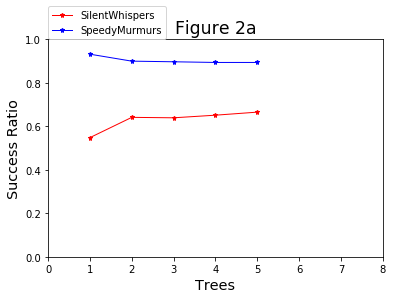

In [4]:
attempts = 1
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

plt.figure()
plt.title('Figure 2a', size='xx-large')
plt.ylabel('Success Ratio', size='x-large')
plt.xlabel('Trees', size='x-large')
plt.axis([0,8,0.0,1.0])

plt.plot(range(1,max_trees), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,max_trees), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)


## 2b
The x-axis is the number of trees (or landmarks) used, and the y-axis is the number of hops a transaction took to reach its destination. Each point on the plot is the value of CREDIT_NETWORK_DELAY_AV in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

Same simulations as 2a.


### Generate plots from data

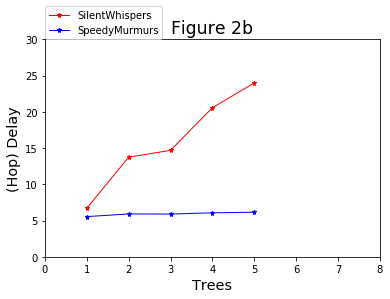

In [5]:
attempts = 1
key = 'CREDIT_NETWORK_DELAY_AV'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

plt.figure()
plt.title('Figure 2b', size='xx-large')
plt.ylabel('(Hop) Delay', size='x-large')
plt.xlabel('Trees', size='x-large')
plt.axis([0,8,0,30])

plt.plot(range(1,6), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,6), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)


## 2c
The x-axis is the number of times a failed transaction should be retried, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in \_singles.txt for the run with that many retries. All of these runs use 3 landmarks.

### Run simulations

In [ ]:
trees = 3
transaction_set = 0
for attempt in range(1, max_attempts+1):
    run_static(transaction_set, silentwhispers, attempt, trees)
    run_static(transaction_set, speedymurmurs, attempt, trees)
print('Done.')  
    

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 8 3


### Generate plots from data

In [6]:
attempts = 10
trees = 3
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles_attempts(silentwhispers, attempts, trees, key)
speedymurmurs_data = extract_from_singles_attempts(speedymurmurs, attempts, trees, key)

plt.figure()
plt.title('Figure 2c', size='xx-large')
plt.ylabel('Success Ratio', size='x-large')
plt.xlabel('Attempts', size='x-large')
plt.axis([0,10,0.0,1.0])

plt.plot(range(1,10), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,10), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)


FileNotFoundError: [Errno 2] No such file or directory: 'data/static/READABLE_FILE_SW-PER-MUL-67149/0/CREDIT_NETWORK-STATIC-1000.0-TREE_ROUTE_SILENTW-false-true-1-2000.0-RANDOM_PARTITIONER-10/_singles.txt'

## Figure 3 Plots

## 3a
This is generated from the Ripple transaction data set, not from the simulator. The x-axis is the epoch number with epochs being of length 1000\*delta\_av, where delta\_av is calculated from the data set as the average time between two subsequent transactions. The y-axis is either the number of transactions or the number of transactions or link changes in that epoch. The number of transactions are determined by counting lines in the ripple transaction data set (for the epoch in question), and the link changes are determined by counting the number of lines in the newlinks data set (jan2013-newlinks-lcc-sorted-uniq-t\*.txt) for the epoch in question.

### Generate plots from data

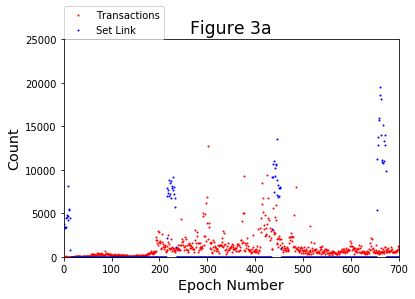

In [8]:
def get_epoch_length(transactions_file):
    transactions_list = []
    for i in range(1, 10):
        transactions_list = read_transactions_file(transactions_file.format(i), transactions_list)

    # sum the time between subsequent transctions
    sum_delta = 0
    for i in range(1, len(transactions_list)):
        sum_delta += transactions_list[i][0] - transactions_list[i - 1][0]
    delta_av = sum_delta/len(transactions_list)
    return (delta_av * 1000, transactions_list)

def read_link_changes_files(link_changes_file):
    link_changes_list = []
    for i in range(1, 10):
        link_changes_list = read_link_changes_file(link_changes_file.format(i), link_changes_list)
    return link_changes_list

def read_link_changes_file(link_changes_file, link_changes_list = []):
    with open(link_changes_file, 'r') as link_changes:
        count = 0
        for link_change in link_changes:
            lc = link_change.split(" ")
            # time, source, destination, amount
            link_changes_list.append((int(lc[0]), lc[1], lc[2], lc[3]))

        return link_changes_list

def calculate_events_per_epoch(epoch_length, events):
    cur_epoch = 1
    next_epoch_starts = epoch_length

    events_in_current_epoch = 0
    events_per_epoch = {}
    for event in events:
        if event[0] < next_epoch_starts:
            events_in_current_epoch += 1
        else:
            events_per_epoch[cur_epoch] = events_in_current_epoch
            next_epoch_starts += epoch_length
            cur_epoch += 1
            # should be 1 because it needs to include the current transaction
            events_in_current_epoch = 1
    return events_per_epoch

def read_transactions_file(transactions_file, transactions_list = []):
    with open(transactions_file, 'r') as transactions:
        count = 0
        for transaction in transactions:
            t = transaction.split(" ")
            if len(t) == 4:
                # time, amount, source, destination
                transactions_list.append((int(t[0]), t[1], t[2], t[3]))
            elif len(t) == 3:
                # time, amount, source, destination
                transactions_list.append((count, t[1], t[2], t[3]))
                count += 1

        return transactions_list

transactions_file = '../data/finalSets/dynamic/jan2013-trans-lcc-noself-uniq-{0}.txt'
link_changes_file = '../data/finalSets/dynamic/jan2013-newlinks-lcc-sorted-uniq-t{0}.txt'
epoch_length, transactions = get_epoch_length(transactions_file)
link_changes = read_link_changes_files(link_changes_file)


transactions_per_epoch = calculate_events_per_epoch(epoch_length, transactions)
link_changes_per_epoch = calculate_events_per_epoch(epoch_length, link_changes)
lc_per_epoch_list = dict_to_list(link_changes_per_epoch, 801)

plt.figure()
plt.title('Figure 3a', size='xx-large')
plt.ylabel('Count', size='x-large')
plt.xlabel('Epoch Number', size='x-large')
plt.axis([0,700,0,25000])

plt.plot(range(1, 801), transactions_per_epoch.values(), 'ro', markersize=1, linewidth=1, label='Transactions')
plt.plot(range(1, 801), lc_per_epoch_list, 'bo', markersize=1, linewidth=1, label='Set Link')
plt.legend(loc=(0,1), scatterpoints=10)


## 3b
The x-axis is the epoch number with epochs calculated as above. The y-axis is the number of stabilization messages for that epoch. The number of stabilization messages can be determined from the cnet-stab.txt file which tracks stabilization messages per epoch. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [99]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
print('Done.')

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 7
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 8
Done.


### Generate plots from data

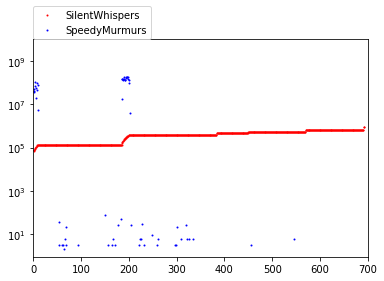

In [106]:
stab_file = '/cnet-stab.txt'

sw_stab_messages_list = []
sm_stab_messages_list = []
sw_stab_messages_dict = {}
sm_stab_messages_dict = {}
for step in range(0,9):
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + stab_file
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + stab_file

    # create dict of stab message values for both sw and sm
    new_dict_sw = convert_kv_file_to_dict(sw_file_path)
    new_dict_sm = convert_kv_file_to_dict(sm_file_path)

    sw_stab_messages_dict = merge_dicts(new_dict_sw, sw_stab_messages_dict)
    sm_stab_messages_dict = merge_dicts(new_dict_sm, sm_stab_messages_dict)

sw_stab_messages_list = dict_to_list(sw_stab_messages_dict, 801)
sm_stab_messages_list = dict_to_list(sm_stab_messages_dict, 801)

plt.yscale('log')
plt.axis([0,700,0,1e+10])
plt.plot(range(1, 801), sw_stab_messages_list, 'ro', markersize=1, linewidth=1, label='SilentWhispers')
plt.plot(range(1, 801), sm_stab_messages_list, 'bo', markersize=1, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)

## 3c
The x-axis is the epoch number with epochs calculated as above. The y-axis is the ratio of the success rate of SpeedyMurmurs or SilentWhispers to the success rate of Ford-Fulkerson. The lines in the plot are represented as a moving average over 50 epochs. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [12]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
    run_dynamic(0, maxflow, 2, 3, step)
print('Done.')

Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 0
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 0
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 0
Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 1
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 1
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 1
Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 2
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 2
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 2
Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 3
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 3
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 3
Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 4
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 4
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 4
Running: java -cp bin/ treeembedding.tests.Dynamic 0 0 5
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 5
Running: java -cp bin/ tre

### Generate plots from data

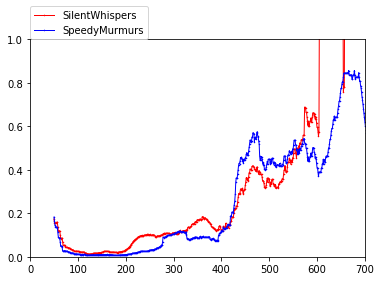

In [113]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

filename = '/cnet-succR.txt'

sw_succr_list = []
sm_succr_list = []
sw_succr_dict = {}
sm_succr_dict = {}
m_succr_dict = {}
for step in range(0, 9):
    m_file_path = get_dynamic_data_path(maxflow, 3, 2, step) + filename
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + filename
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + filename

    # get succR for SW for each epoch
    sw_new_dict = convert_kv_file_to_dict(sw_file_path)
    sm_new_dict = convert_kv_file_to_dict(sm_file_path)
    m_new_dict = convert_kv_file_to_dict(m_file_path)
    
    sw_succr_dict = merge_dicts(sw_new_dict, sw_succr_dict)
    sm_succr_dict = merge_dicts(sm_new_dict, sm_succr_dict)
    m_succr_dict = merge_dicts(m_new_dict, m_succr_dict)

# update SW dict by dividing each value by the corresponding value in the M dict
for k,v in sw_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sw_succr_dict[k] = 1
        else:
            sw_succr_dict[k] = v/m_succr_dict[k]

# update SM dict by dividing each value by the corresponding value in the M dict
for k,v in sm_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sm_succr_dict[k] = 1
        else:
            sm_succr_dict[k] = v/m_succr_dict[k]

sw_succr_list = dict_to_list(sw_succr_dict, 801)
sm_succr_list = dict_to_list(sm_succr_dict, 801)

plt.axis([0,700,0,1])
plt.plot(range(50, 801), running_mean(sw_succr_list, 50), 'r*-', markersize=1, linewidth=1, label='SilentWhispers')

plt.plot(range(50, 801), running_mean(sm_succr_list, 50), 'b*-', markersize=1, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)

